# **Part 1**
# Import Data and Prepare for Modeling

In [1]:
# import data
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df_jollyes_revenue = pd.read_csv("https://raw.githubusercontent.com/yjzhou217/Technical-test/refs/heads/main/jollyes_case_study_data.csv")

print("Columns:", df_jollyes_revenue.columns.tolist())

Columns: ['DATE', 'STORES_OPEN', 'REVENUE']


In [2]:
# convert DATE to datetime
df_jollyes_revenue["DATE"] = pd.to_datetime(df_jollyes_revenue["DATE"], errors="coerce")
df_jollyes_revenue = df_jollyes_revenue.sort_values("DATE").reset_index(drop=True)

In [3]:
# check missing value
print("\nMissing value by columns:")
print(df_jollyes_revenue.isna().sum())


Missing value by columns:
DATE           0
STORES_OPEN    0
REVENUE        0
dtype: int64


In [4]:
# check deplicated dates
dup_dates = df_jollyes_revenue["DATE"].duplicated().sum()
print(f"\nNumber of duplicated DATE values: {dup_dates}")


Number of duplicated DATE values: 0


In [5]:
# check the date range
print("\nDate range:")
print("Start:", df_jollyes_revenue["DATE"].min())
print("End:  ", df_jollyes_revenue["DATE"].max())
print("Rows: ", len(df_jollyes_revenue))


Date range:
Start: 2023-02-01 00:00:00
End:   2026-01-31 00:00:00
Rows:  1096


In [6]:
# check if the dates are continuous
date_diff = df_jollyes_revenue["DATE"].diff().dropna()
non_daily_gaps = date_diff[date_diff != pd.Timedelta(days=1)]

print(f"\nNumber of non-daily gaps: {len(non_daily_gaps)}")
if len(non_daily_gaps) > 0:
    print(non_daily_gaps.head(10))


Number of non-daily gaps: 0


# **Part 2:**
# Classify data into Features

In [7]:
# copy one df
df_feat = df_jollyes_revenue.copy()

### 2.1 Date features
Dates have periodicity, with different cycles exerting varying influences on revenue. For instance, consumption patterns differ between weekends and weekdays, seasonal variations affect spending levels, and periodic fluctuations may occur during specific weeks of year.

In [8]:
df_feat["day_of_week"] = df_feat["DATE"].dt.dayofweek
df_feat["is_weekend"] = df_feat["day_of_week"].isin([5,6]).astype(int)
df_feat["month"] = df_feat["DATE"].dt.month
df_feat["week_of_year"] = df_feat["DATE"].dt.isocalendar().week.astype(int)
df_feat["day_of_month"] = df_feat["DATE"].dt.day
df_feat["quarter"] = df_feat["DATE"].dt.quarter

### 2.2 Store features
The status of stores may directly influence the daily revenue. Generally, the more stores that open, the higher the revenue. 

In [9]:
import matplotlib.pyplot as plt

In [10]:
df_plot_compare = df_jollyes_revenue.copy()
df_plot_compare["DATE"] = pd.to_datetime(df_plot_compare["DATE"], errors="coerce")
df_plot_compare = df_plot_compare.sort_values("DATE").reset_index(drop=True)

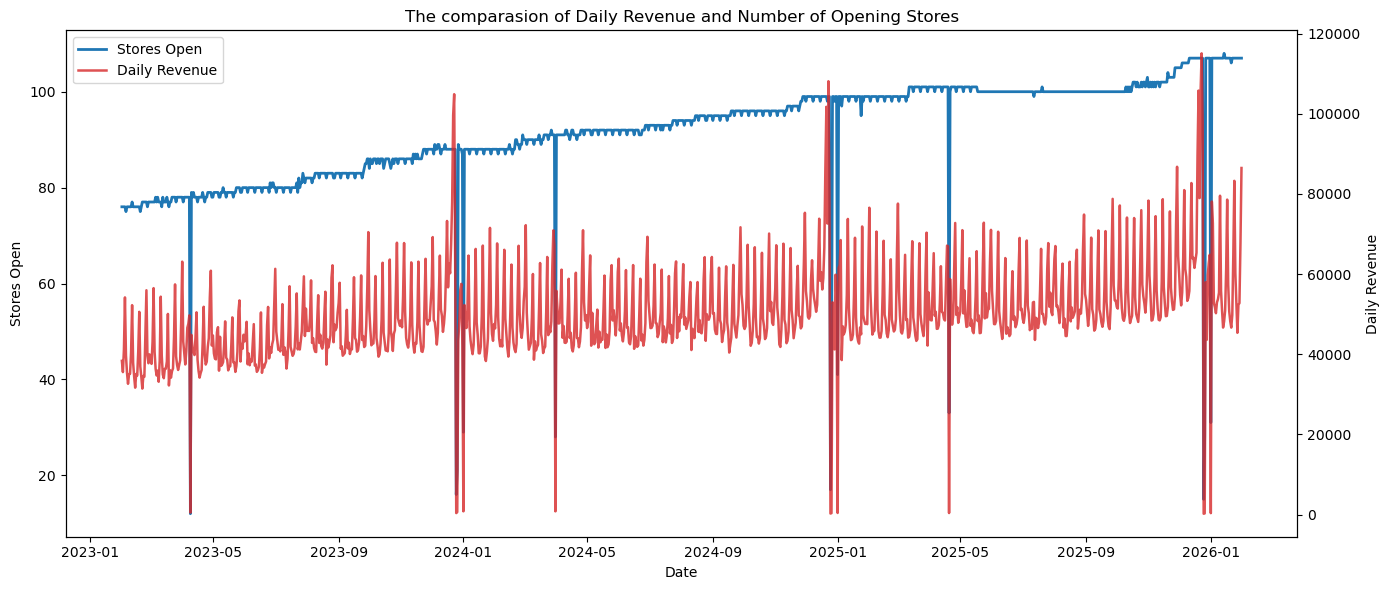

In [11]:
# create figure that compares the daily revenue and the number of opening stores
fig, ax1 = plt.subplots(figsize=(14,6))

# left: the number of opening stores
ax1.plot(df_plot_compare["DATE"], df_plot_compare["STORES_OPEN"], label="Stores Open", linewidth=2, color="tab:blue")
ax1.set_xlabel("Date")
ax1.set_ylabel("Stores Open")
ax1.tick_params(axis='y')

# right: daily revenue
ax2 = ax1.twinx()
ax2.plot(df_plot_compare["DATE"], df_plot_compare["REVENUE"], label="Daily Revenue", linewidth=1.8, alpha=0.8, color="tab:red")
ax2.set_ylabel("Daily Revenue")
ax2.tick_params(axis='y')

plt.title("The comparasion of Daily Revenue and Number of Opening Stores")

# Combine
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()

As shown in the chart above, both the number of stores and daily revenue have exhibited an upward trend over the past three years. Occasional closures have caused sudden dips in daily revenue. Overall, revenue fluctuations have been more pronounced than changes in the number of open stores.

Therefore, to take it a step further, calculate the revenue per store can help to define the influence of "more stores open" VS "better performance per store".

In [12]:
df_feat["revenue_per_store"] = df_feat["REVENUE"] / df_feat["STORES_OPEN"]

### 2.3 Lag features
Place the revenue from “X” days ago in the “Today” row.

In [13]:
df_feat["rev_lag_7"] = df_feat["REVENUE"].shift(7)
df_feat["rev_lag_14"] = df_feat["REVENUE"].shift(14)
df_feat["rev_lag_28"] = df_feat["REVENUE"].shift(28)

df_feat["rps_lag_7"] = df_feat["revenue_per_store"].shift(7)

### 2.4 Check the added Feature Data

In [14]:
print("New columns created:")
print([
    "day_of_week", 
    "is_weekend", 
    "month", 
    "week_of_year",
    "day_of_month", 
    "quarter",
    "revenue_per_store",
    "rev_lag_7", "rev_lag_14", "rev_lag_28",
    "rps_lag_7"
])

print("\nHead (first 10 rows):")
print(df_feat.head(10))

print("\nMissing values after feature engineering (expected in first rows due to lags):")
print(df_feat.isna().sum().sort_values(ascending=False))

New columns created:
['day_of_week', 'is_weekend', 'month', 'week_of_year', 'day_of_month', 'quarter', 'revenue_per_store', 'rev_lag_7', 'rev_lag_14', 'rev_lag_28', 'rps_lag_7']

Head (first 10 rows):
        DATE  STORES_OPEN   REVENUE  day_of_week  is_weekend  month  \
0 2023-02-01           76  38352.56            2           0      2   
1 2023-02-02           76  35545.57            3           0      2   
2 2023-02-03           76  41205.32            4           0      2   
3 2023-02-04           76  54190.56            5           1      2   
4 2023-02-05           75  39687.31            6           1      2   
5 2023-02-06           76  35367.16            0           0      2   
6 2023-02-07           76  32628.52            1           0      2   
7 2023-02-08           76  35041.45            2           0      2   
8 2023-02-09           76  35144.82            3           0      2   
9 2023-02-10           76  40536.67            4           0      2   

   week_of_year  

In [15]:
# drop rows with NA caused by the lag
df_model = df_feat.dropna().reset_index(drop=True)

print("\nShape before dropna:", df_feat.shape)
print("Shape after dropna: ", df_model.shape)

print("\nModel-ready preview:")
print(df_model.head())


Shape before dropna: (1096, 14)
Shape after dropna:  (1068, 14)

Model-ready preview:
        DATE  STORES_OPEN   REVENUE  day_of_week  is_weekend  month  \
0 2023-03-01           77  39054.75            2           0      3   
1 2023-03-02           77  37599.91            3           0      3   
2 2023-03-03           77  43132.47            4           0      3   
3 2023-03-04           77  56508.11            5           1      3   
4 2023-03-05           77  40609.68            6           1      3   

   week_of_year  day_of_month  quarter  revenue_per_store  rev_lag_7  \
0             9             1        1         507.204545   34595.19   
1             9             2        1         488.310519   34385.69   
2             9             3        1         560.161948   44647.87   
3             9             4        1         733.871558   55974.09   
4             9             5        1         527.398442   39638.30   

   rev_lag_14  rev_lag_28   rps_lag_7  
0    35072.71

# **Part 3:**
# Split into time-based validation data sets
To forecast a future date, the validation process reserves the final period for verification, thereby approximating real-world usage patterns more closely. An eight-week cycle, being a complete period closer to the target date, reflects recent income fluctuation patterns without rendering the training dataset excessively small.


In [16]:
val_days = 8 * 7

train_df = df_model.iloc[:-val_days].copy()
val_df = df_model.iloc[-val_days:].copy()

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)

print("\nTrain date range:")
print(train_df["DATE"].min(), "to", train_df["DATE"].max())

print("Validation date range:")
print(val_df["DATE"].min(), "to", val_df["DATE"].max())


Train shape: (1012, 14)
Validation shape: (56, 14)

Train date range:
2023-03-01 00:00:00 to 2025-12-06 00:00:00
Validation date range:
2025-12-07 00:00:00 to 2026-01-31 00:00:00


# **Part 4:**
# Random Forest Model Tuning
Revenue is a "continuous variable", so I use a regression model. Random Forest will be used as the main model because it generally provides more stable and accurate predictions by averaging across many trees.

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
feature_cols = [
    "day_of_week", 
    "is_weekend", 
    "month", 
    "week_of_year",
    "day_of_month", 
    "quarter",
    "STORES_OPEN",
    "rev_lag_7", "rev_lag_14", "rev_lag_28",
    "rps_lag_7"
]
target_col = ["REVENUE"]

# build X and Y for training and testing
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

print("\nX_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)



X_train shape: (1012, 11)
X_val shape: (56, 11)
y_train shape: (1012, 1)
y_val shape: (56, 1)


In [19]:
tscv = TimeSeriesSplit(n_splits=5)  # tscv: time-series cross-validation

param_grid_rf = {
    "n_estimators":[200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.5, 1.0]
}

grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    cv=tscv,
    scoring="r2",
    n_jobs=-1,
    return_train_score=True
)

grid_rf.fit(X_train, y_train)

print("Best RandomForest hyperparameters:", grid_rf.best_params_)
print(f"Best RandomForest cross-validation R-squared:{grid_rf.best_score_:.3f}")

# Retain best RF on full training data set
best_rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    **grid_rf.best_params_
)
best_rf.fit(X_train, y_train)
best_params = grid_rf.best_params_

Best RandomForest hyperparameters: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 300}
Best RandomForest cross-validation R-squared:0.660


In [20]:
# R-squared on training and validation data
train_r2 = r2_score(y_train, best_rf.predict(X_train))
print(f"Train R-squared: {train_r2:.3f}")

val_r2 = r2_score(y_val, best_rf.predict(X_val))
print(f"Validation R-squared: {val_r2:.3f}")

Train R-squared: 0.961
Validation R-squared: 0.510


The model achieved a high training R^2 (0.961), but the more relevant metrics are cross-validation R^2 (0.660) for tuning and validation R^2 (0.510) on the final holdout period, which suggests good short-term predictive performance.

# **Part 5:**
# 2026-02-07 Final Forecast
I noticed that over the past month, STORES_OPEN has remained largely stable at 107, with only a few days registering 106 or 108. Furthermore, 7 February was neither a prominent public holiday nor a special trading day. Therefore, I have separately assumed STORES_OPEN values of 106, 107, and 108 for 2026-02-07, and generated corresponding revenue predictions within the same feature engineering and trained revenue model framework. Should additional time permit, I shall establish more rigorous forecasts for store counts or utilise planned store openings provided by the business side as input.

In [28]:
target_date = pd.Timestamp("2026-02-07")

def get_value_on_date(df, col, d):
    return df.loc[df["DATE"] == d, col].iloc[0]

# Features
day_of_week = target_date.dayofweek
is_weekend = int(day_of_week in [5, 6])
month = target_date.month
week_of_year = int(target_date.isocalendar().week)
day_of_month = target_date.day
quarter = target_date.quarter

rev_lag_7  = get_value_on_date(df_feat, "REVENUE", target_date - pd.Timedelta(days=7))
rev_lag_14 = get_value_on_date(df_feat, "REVENUE", target_date - pd.Timedelta(days=14))
rev_lag_28 = get_value_on_date(df_feat, "REVENUE", target_date - pd.Timedelta(days=28))

rps_lag_7 = get_value_on_date(df_feat, "revenue_per_store", target_date - pd.Timedelta(days=7))

# if STORES_OPEN = 106/107/108
stores_scenarios = [106, 107, 108, 30, 80, 200]

print("\nScenario predictions for 2026-02-07:")
for stores_open in stores_scenarios:
    X_target = pd.DataFrame([{
        "day_of_week": day_of_week,
        "is_weekend": is_weekend,
        "month": month,
        "week_of_year": week_of_year,
        "day_of_month": day_of_month,
        "quarter": quarter,
        "STORES_OPEN": stores_open,
        "rev_lag_7": rev_lag_7,
        "rev_lag_14": rev_lag_14,
        "rev_lag_28": rev_lag_28,
        "rps_lag_7": rps_lag_7
    }])

    pred = float(best_rf.predict(X_target)[0])
    print(f"STORES_OPEN={stores_open} -> Predicted REVENUE = {pred:,.2f}")


Scenario predictions for 2026-02-07:
STORES_OPEN=106 -> Predicted REVENUE = 74,455.93
STORES_OPEN=107 -> Predicted REVENUE = 74,455.93
STORES_OPEN=108 -> Predicted REVENUE = 74,455.93
STORES_OPEN=30 -> Predicted REVENUE = 61,457.25
STORES_OPEN=80 -> Predicted REVENUE = 70,782.31
STORES_OPEN=200 -> Predicted REVENUE = 74,455.93


In [25]:
pd.Series(best_rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

rev_lag_28      0.271567
rev_lag_7       0.209150
STORES_OPEN     0.172788
rev_lag_14      0.129998
rps_lag_7       0.074321
week_of_year    0.060848
day_of_month    0.038198
day_of_week     0.021648
month           0.014363
is_weekend      0.003641
quarter         0.003477
dtype: float64

In [27]:
print(df_jollyes_revenue["STORES_OPEN"].min(), df_jollyes_revenue["STORES_OPEN"].max())
print(df_jollyes_revenue["STORES_OPEN"].describe())

12 108
count    1096.000000
mean       91.731752
std        11.083046
min        12.000000
25%        86.000000
50%        93.000000
75%       100.000000
max       108.000000
Name: STORES_OPEN, dtype: float64
